In [701]:
FUENTES_DIR  = '../Fuentes'
DATOS_DIR   = '../Datos/' 

import sys
sys.path.append(FUENTES_DIR)

import pandas as pd
import numpy as np
from matplotlib import pylab as plt
from sklearn import model_selection,preprocessing, metrics
from ClassPerceptron import Perceptron

In [702]:
datos = pd.read_csv(DATOS_DIR + "automobile-simple.csv")
print(datos.head())
print(len(datos))

          make fuel-type num-of-doors   body-style  curb-weight  engine-size  \
0  alfa-romero       gas          two  convertible         2548          130   
1  alfa-romero       gas          two  convertible         2548          130   
2  alfa-romero       gas          two    hatchback         2823          152   
3         audi       gas         four        sedan         2337          109   
4         audi       gas         four        sedan         2824          136   

   horsepower  city-mpg  highway-mpg    price      volume  eco-rating  
0       111.0        21           27  13495.0  528019.904   33.297462  
1       111.0        21           27  16500.0  528019.904   33.297462  
2       154.0        19           26  16500.0  587592.640   30.898272  
3       102.0        24           30  13950.0  634816.956   42.697819  
4       115.0        18           22  17450.0  636734.832   27.997459  
205


In [703]:
print(datos.dtypes)

make             object
fuel-type        object
num-of-doors     object
body-style       object
curb-weight       int64
engine-size       int64
horsepower      float64
city-mpg          int64
highway-mpg       int64
price           float64
volume          float64
eco-rating      float64
dtype: object


# a) Tipos de atributos
- make: nominal
- fuel-type: nominal
- num-of-doors: ordinal
- body-style: nominal
- curb-weight: discreto
- engine-size: discreto
- horsepower: contínuo
- city-mpg: discreto
- highway-mpg: discreto
- price: continuo
- volume: continuo
- eco-rating: continuo

# b)
Eliminamos las filas con nulos, pasamos de 205 registros a 197

In [704]:
datos = datos.dropna()
print(datos.info())
print(len(datos))

<class 'pandas.core.frame.DataFrame'>
Index: 197 entries, 0 to 204
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   make          197 non-null    object 
 1   fuel-type     197 non-null    object 
 2   num-of-doors  197 non-null    object 
 3   body-style    197 non-null    object 
 4   curb-weight   197 non-null    int64  
 5   engine-size   197 non-null    int64  
 6   horsepower    197 non-null    float64
 7   city-mpg      197 non-null    int64  
 8   highway-mpg   197 non-null    int64  
 9   price         197 non-null    float64
 10  volume        197 non-null    float64
 11  eco-rating    197 non-null    float64
dtypes: float64(4), int64(4), object(4)
memory usage: 20.0+ KB
None
197


# c) calcular matriz de correlacion
La matriz de correlación mide la relación lineal entre dos variables. Esta medida se calcula utilizando las desviaciones estándar y las medias de las variables, por lo que no se ve afectada por la escala de las variables. Es por esto que no es neceario tener los atributos normalizados para realizar esto


In [705]:
datos["num-of-doors"].unique()

array(['two', 'four'], dtype=object)

In [706]:
mapeo = { "num-of-doors":{"two":1, "four":0}}
datos.replace(mapeo,inplace=True)
datos_num = datos.iloc[:, 4:]
datos_num["two-doors"]=datos["num-of-doors"]

ultima_columna = datos_num.columns[-1]
datos_num = datos_num[[ultima_columna] + list(datos_num.columns[:-1])]

datos_num.head()

,two-doors,curb-weight,engine-size,horsepower,city-mpg,highway-mpg,price,volume,eco-rating
0,1,2548,130,111.0,21,27,13495.0,528019.904,33.297462
1,1,2548,130,111.0,21,27,16500.0,528019.904,33.297462
2,1,2823,152,154.0,19,26,16500.0,587592.640,30.898272
3,0,2337,109,102.0,24,30,13950.0,634816.956,42.697819
4,0,2824,136,115.0,18,22,17450.0,636734.832,27.997459


In [707]:
datos_num.corr()

,two-doors,curb-weight,engine-size,horsepower,city-mpg,highway-mpg,price,volume,eco-rating
two-doors,1.000000,-0.213501,-0.028087,0.099274,0.035202,0.053354,-0.046571,-0.477374,0.034539
curb-weight,-0.213501,1.000000,0.848932,0.759925,-0.755559,-0.800113,0.834732,0.822823,-0.842957
engine-size,-0.028087,0.848932,1.000000,0.825286,-0.655737,-0.684662,0.873708,0.592571,-0.723965
horsepower,0.099274,0.759925,0.825286,1.000000,-0.821960,-0.803658,0.811953,0.449278,-0.839619
city-mpg,0.035202,-0.755559,-0.655737,-0.821960,1.000000,0.972407,-0.692948,-0.554978,0.976650
highway-mpg,0.053354,-0.800113,-0.684662,-0.803658,0.972407,1.000000,-0.708659,-0.608072,0.984258
price,-0.046571,0.834732,0.873708,0.811953,-0.692948,-0.708659,1.000000,0.631578,-0.747982
volume,-0.477374,0.822823,0.592571,0.449278,-0.554978,-0.608072,0.631578,1.000000,-0.598520
eco-rating,0.034539,-0.842957,-0.723965,-0.839619,0.976650,0.984258,-0.747982,-0.598520,1.000000


# d) Entrenar perceptrón para ver si un auto es ecológico
- Es ecológico si supera la media de eco-rating
- comparar rendimientos sin normalizar, usar MinMaxScaler y usando StandardScaler
- entrenar nuevamente sacando dos atributos fuertemente correlacionados (uno negativo y otro positivo). Las columnas a sacar serían highwat-mpg y curb-weight


In [708]:
sacar_columnas = 0
if sacar_columnas:
    datos_num = datos_num.drop(columns=['highway-mpg'])
    datos_num = datos_num.drop(columns=['curb-weight'])
datos_num.head()

,two-doors,curb-weight,engine-size,horsepower,city-mpg,highway-mpg,price,volume,eco-rating
0,1,2548,130,111.0,21,27,13495.0,528019.904,33.297462
1,1,2548,130,111.0,21,27,16500.0,528019.904,33.297462
2,1,2823,152,154.0,19,26,16500.0,587592.640,30.898272
3,0,2337,109,102.0,24,30,13950.0,634816.956,42.697819
4,0,2824,136,115.0,18,22,17450.0,636734.832,27.997459


In [709]:
media = datos_num["eco-rating"].mean()
X = np.array(datos_num.iloc[:,1:-1])
T = np.array((datos_num['eco-rating'] > media) * 1) 

print(len(X))
print(len(T))
print(T)

197
197
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 0 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1
 0 0 1 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0 0 1
 1 0 0 0 0 0 0 0 0 0 0 0]


In [710]:
X_train, X_test, T_train, T_test = model_selection.train_test_split(
        X, T, test_size=0.30, random_state=42)

normalizar = 1
if normalizar:
    normalizador= preprocessing.MinMaxScaler()
    #normalizador= preprocessing.StandardScaler() #media y desvío
    X_train = normalizador.fit_transform(X_train)
    X_test  = normalizador.transform(X_test)

print(X_test)

[[ 0.36152056  0.23857868  0.21383648  0.23529412  0.28571429  0.09072391
   0.49330138]
 [ 0.16679597  0.14720812  0.12578616  0.64705882  0.62857143  0.01422751
   0.16525915]
 [ 0.78238945  0.75126904  0.8427673   0.          0.02857143  0.99536196
   0.96461858]
 [ 0.34212568  0.24873096  0.42767296  0.23529412  0.31428571  0.15170793
   0.30720162]
 [ 0.26415826  0.18781726  0.13836478  0.41176471  0.42857143  0.09213413
   0.33318815]
 [ 0.55236618  0.40609137  0.41509434  0.23529412  0.25714286  0.24512692
   0.75265723]
 [ 0.86384794  1.23350254  0.85534591 -0.02941176 -0.08571429  1.2623629
   0.98834982]
 [ 0.34794414  0.30964467  0.22641509  0.32352941  0.37142857  0.11679724
   0.52691498]
 [ 0.14972847  0.14720812  0.13836478  0.67647059  0.68571429  0.03688499
   0.18195747]
 [ 0.57719162  0.55837563  0.71069182  0.14705882  0.14285714  0.3585083
   0.55888639]
 [ 0.27967417  0.24365482  0.2327044   0.35294118  0.42857143  0.08953306
   0.50231362]
 [ 0.73390225  0.751269

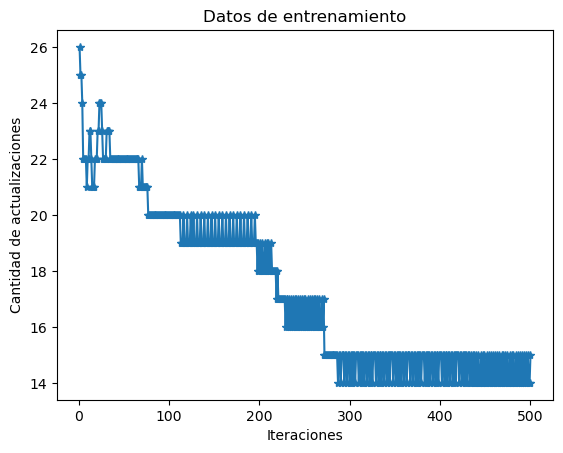

In [711]:
ppn = Perceptron(alpha=0.0001, n_iter=500, random_state=None) #random_state=None significa que no utiliza una semilla para la generación de números aleatorios
ppn.fit(X_train, T_train)

plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='*')
plt.title('Datos de entrenamiento')
plt.xlabel('Iteraciones')
plt.ylabel('Cantidad de actualizaciones')
plt.show()

In [712]:
Y_test = 0 * len(X_test) #necesario inicializar el array en 0?
Y_test = ppn.predict(X_test)
nAciertos = np.sum(Y_test == T_test)
print("Dimensiones de Y_test:", Y_test.shape)
print("Dimensiones de T_test:", T_test.shape)
print("cantidad de tests: ", X_test.shape[0])
print("aciertos: ", nAciertos)
print("%% de aciertos = %.2f %%" % (100 * nAciertos / X_test.shape[0]))

Dimensiones de Y_test: (60,)
Dimensiones de T_test: (60,)
cantidad de tests:  60
aciertos:  52
% de aciertos = 86.67 %


In [713]:
print(Y_test)
print("---------------")
print(T_test)

[1 1 0 0 1 0 0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 1 1 0 1 0 1 1 1 0 0 0 0 1 1 0 1
 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 1]
---------------
[0 1 0 0 1 0 0 1 1 0 1 0 0 0 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 0 0 0 1 1 1 1 1
 1 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0]


## Resultados: (de 5 medidas)
- con todas las columnas
    - sin normalizar: 57%
    - con MinMaxScaler: entre 80 y 97%
    - con StandardScaler: entre 92 y 95%
- sacando dos columnas con alta correlación
    - sin normalizar: 57%
    - con MinMaxScaler: entre 73 y 92%
    - con StandardScaler: entre 91 y 95%
    
## Conclusión:
El trabajar con las columnas con mayor correlación nos da una mejor precisión en nuestro modelo. De todas formas ya habían varias columnas con alta correlación respecto del atributo a predecir, por lo cual no fue tan influyente el hecho de no operar con ellas